In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin

In [2]:
#!pip install pyarrow

### Read data

In [3]:
df = pd.read_feather(r"..\data\stack_overflow.feather")  

In [4]:
df.head(3)

,respondent,main_branch,hobbyist,age,age_1st_code,age_first_code_cut,comp_freq,comp_total,converted_comp,country,...,survey_length,trans,undergrad_major,webframe_desire_next_year,webframe_worked_with,welcome_change,work_week_hrs,years_code,years_code_pro,age_cat
0,36.0,"I am not primarily a developer, but I write co...",Yes,34.0,30.0,adult,Yearly,60000.0,77556.0,United Kingdom,...,Appropriate in length,No,"Computer science, computer engineering, or sof...",Express;React.js,Express;React.js,Just as welcome now as I felt last year,40.0,4.0,3.0,At least 30
1,47.0,I am a developer by profession,Yes,53.0,10.0,child,Yearly,58000.0,74970.0,United Kingdom,...,Appropriate in length,No,"A natural science (such as biology, chemistry,...",Flask;Spring,Flask;Spring,Just as welcome now as I felt last year,40.0,43.0,28.0,At least 30
2,69.0,I am a developer by profession,Yes,25.0,12.0,child,Yearly,550000.0,594539.0,France,...,Too short,No,"Computer science, computer engineering, or sof...",Django;Flask,Django;Flask,Just as welcome now as I felt last year,40.0,13.0,3.0,Under 30


In [5]:
df["job_sat"].value_counts()

Very satisfied           879
Slightly satisfied       680
Slightly dissatisfied    342
Neither                  201
Very dissatisfied        159
Name: job_sat, dtype: int64

### Is mean annual compensation different for different level sof job satisfaction?

### Visualising multiple distributions

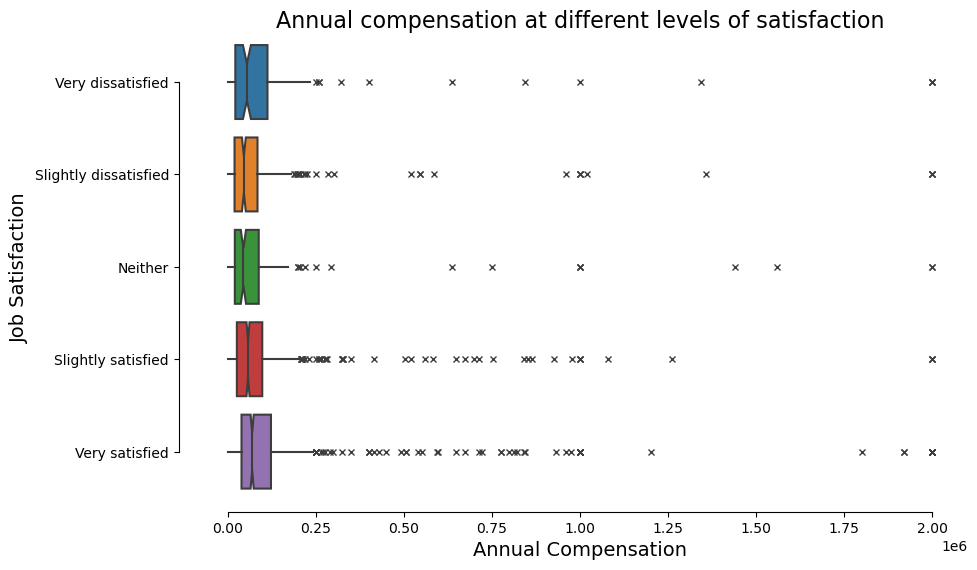

In [6]:
g = plt.figure(figsize=(10,6))
sns.boxplot(#palette=["g", "k"],
    data=df,
    x='converted_comp', 
    y='job_sat',
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    orient="h"
)
plt.xlabel("Annual Compensation", fontsize=14)
plt.ylabel("Job Satisfaction", fontsize=14)
plt.title("Annual compensation at different levels of satisfaction", fontsize=16)
sns.despine(offset=10, trim=True)
plt.show()

### ANOVA


* H0: mean annual compensation is the same for different level sof job satisfaction

* HA: mean annual compensation is different for different level sof job satisfaction

Significance level of 0.2



In [7]:
alpha = 0.2

stats_df = pingouin.anova(data=df,
                          dv="converted_comp", # dependent variable
                          between="job_sat")

stats_df

,Source,ddof1,ddof2,F,p-unc,np2
0,job_sat,4,2256,4.480485,0.001315,0.007882


In [8]:
p_value = stats_df["p-unc"][0]
print("p value = {:.2f}".format(p_value))

if p_value < alpha:
    print("p = {:.2f} < alpha ({}). At least two categories have significantly different compensation, but we don't know which two categories they are. Therefore, we need pairwise tests.".format(p_value, alpha))
else:
    print("No categories have significantly different compensation.")

p value = 0.00
p = 0.00 < alpha (0.2). At least two categories have significantly different compensation, but we don't know which two categories they are. Therefore, we need pairwise tests.


### Pairwise tests

The ANOVA test doesn't tell us which categories had significant differences. Therefore, to pinpoint which categories had differences, we use pairwise t-tests.

In [9]:
pingouin.pairwise_tests(data=df,
                        dv="converted_comp",
                        between="job_sat",
                        padjust="none")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,job_sat,Slightly satisfied,Very satisfied,False,True,-4.009935,1478.622799,two-sided,0.000064,158.564,-0.192931
1,job_sat,Slightly satisfied,Neither,False,True,-0.700752,258.204546,two-sided,0.484088,0.114,-0.068513
2,job_sat,Slightly satisfied,Very dissatisfied,False,True,-1.243665,187.153329,two-sided,0.215179,0.208,-0.145624
3,job_sat,Slightly satisfied,Slightly dissatisfied,False,True,-0.038264,569.926329,two-sided,0.969491,0.074,-0.002719
4,job_sat,Very satisfied,Neither,False,True,1.662901,328.326639,two-sided,0.097286,0.337,0.120115
5,job_sat,Very satisfied,Very dissatisfied,False,True,0.747379,221.666205,two-sided,0.455627,0.126,0.063479
6,job_sat,Very satisfied,Slightly dissatisfied,False,True,3.076222,821.303063,two-sided,0.002166,7.43,0.173247
7,job_sat,Neither,Very dissatisfied,False,True,-0.545948,321.165726,two-sided,0.585481,0.135,-0.058537
8,job_sat,Neither,Slightly dissatisfied,False,True,0.602209,367.730081,two-sided,0.547406,0.118,0.055707
9,job_sat,Very dissatisfied,Slightly dissatisfied,False,True,1.129951,247.570187,two-sided,0.259590,0.197,0.119131


### Bonferroni correction

To reduce the chance of getting _false positives_ due to the repeated pairwise tests, we use Bonferroni correction:

In [10]:
pingouin.pairwise_tests(data=df,
                        dv="converted_comp",
                        between="job_sat",
                        padjust="bonf")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,job_sat,Slightly satisfied,Very satisfied,False,True,-4.009935,1478.622799,two-sided,0.000064,0.000638,bonf,158.564,-0.192931
1,job_sat,Slightly satisfied,Neither,False,True,-0.700752,258.204546,two-sided,0.484088,1.000000,bonf,0.114,-0.068513
2,job_sat,Slightly satisfied,Very dissatisfied,False,True,-1.243665,187.153329,two-sided,0.215179,1.000000,bonf,0.208,-0.145624
3,job_sat,Slightly satisfied,Slightly dissatisfied,False,True,-0.038264,569.926329,two-sided,0.969491,1.000000,bonf,0.074,-0.002719
4,job_sat,Very satisfied,Neither,False,True,1.662901,328.326639,two-sided,0.097286,0.972864,bonf,0.337,0.120115
5,job_sat,Very satisfied,Very dissatisfied,False,True,0.747379,221.666205,two-sided,0.455627,1.000000,bonf,0.126,0.063479
6,job_sat,Very satisfied,Slightly dissatisfied,False,True,3.076222,821.303063,two-sided,0.002166,0.021659,bonf,7.43,0.173247
7,job_sat,Neither,Very dissatisfied,False,True,-0.545948,321.165726,two-sided,0.585481,1.000000,bonf,0.135,-0.058537
8,job_sat,Neither,Slightly dissatisfied,False,True,0.602209,367.730081,two-sided,0.547406,1.000000,bonf,0.118,0.055707
9,job_sat,Very dissatisfied,Slightly dissatisfied,False,True,1.129951,247.570187,two-sided,0.259590,1.000000,bonf,0.197,0.119131


### Conclusion


At alpha = 0.2 and after Benferroni correction, mean annual compensation was found different between:
* Slightly satisfied and Very satisfied programmers
